In [26]:
from medmnist import PathMNIST
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from keras.utils import to_categorical
from keras.models import load_model, Model

from keras.applications import MobileNetV2

import tensorflow as tf

import numpy as np
import cv2

from lime import lime_image
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries

from tf_explain.core.grad_cam import GradCAM

import warnings
warnings.filterwarnings("ignore")

# Data and model preparation

In [2]:
def prepare_data(dataset):
    images = dataset.imgs / 255.0
    labels = to_categorical(dataset.labels, num_classes=9)
    return images, labels

In [3]:
test_dataset = PathMNIST(split="test",  size=64)

In [4]:
X_test, labels = prepare_data(test_dataset)

In [25]:
model_path = "./modele/modelIII.h5"
model = load_model(model_path)

In [6]:
img_array = X_test[150]

In [7]:
 predictions = model.predict(np.expand_dims(img_array, axis=0))

1/1 [==============================] - 0s 385ms/step


In [8]:
predicted_indices = np.argmax(predictions, axis=1)
predicted_indices

array([5], dtype=int64)

# LIME

In [9]:
def generate_textual_explanation(img_array, model, explainer):
    explanation_instance = explainer.explain_instance(img_array, model.predict, top_labels=1, hide_color=0, num_samples=100)
    explanation_text = explanation_instance.get_image_and_mask(explanation_instance.top_labels[0], positive_only=False, num_features=10, hide_rest=False)[0]
    return explanation_text

In [10]:
explainer = LimeImageExplainer()
explanation_text = generate_textual_explanation(img_array, model, explainer)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


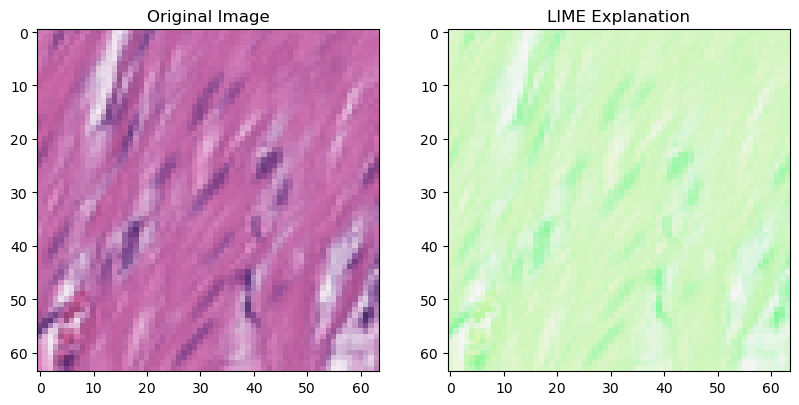

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_array)
plt.title(f"Original Image")
plt.subplot(1, 3, 2)
plt.imshow(explanation_text, cmap='jet', alpha=0.7)
plt.title("LIME Explanation")
plt.show()

# Saliency map

In [12]:
def compute_saliency_map(model, img, class_idx):
    img = tf.convert_to_tensor(img[np.newaxis, ...], dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img)
        predictions = model(img)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, img)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]
    return saliency.numpy()

In [13]:
class_idx = np.argmax(model.predict(np.expand_dims(img_array, axis=0)))
saliency_map = compute_saliency_map(model, img_array, class_idx)

1/1 [==============================] - 0s 49ms/step


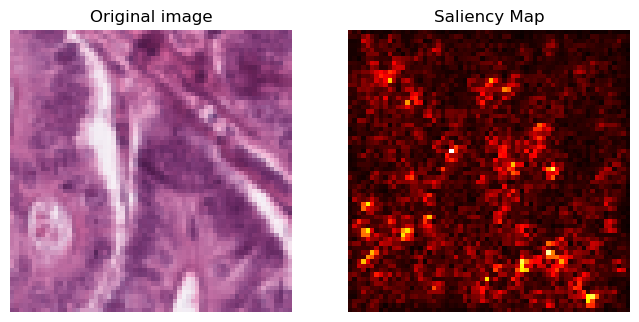

In [24]:
# Wizualizacja
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original image")
plt.imshow(X_test[0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Saliency Map")
plt.imshow(saliency_map, cmap="hot")
plt.axis("off")
plt.show()

# Grad-CAM

In [15]:
def grad_cam(model, img, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img, axis=0))
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap if isinstance(heatmap, np.ndarray) else heatmap.numpy()

In [16]:
for layer in model.layers:
    print(layer.name)

conv2d
batch_normalization
max_pooling2d
conv2d_1
batch_normalization_1
max_pooling2d_1
conv2d_2
batch_normalization_2
max_pooling2d_2
conv2d_3
batch_normalization_3
max_pooling2d_3
global_average_pooling2d
dense
dropout
dense_1


In [17]:
layer_name = "conv2d_3"  
heatmap = grad_cam(model, img_array, layer_name)

### Heatmap in original size (depends on the layer being examined)

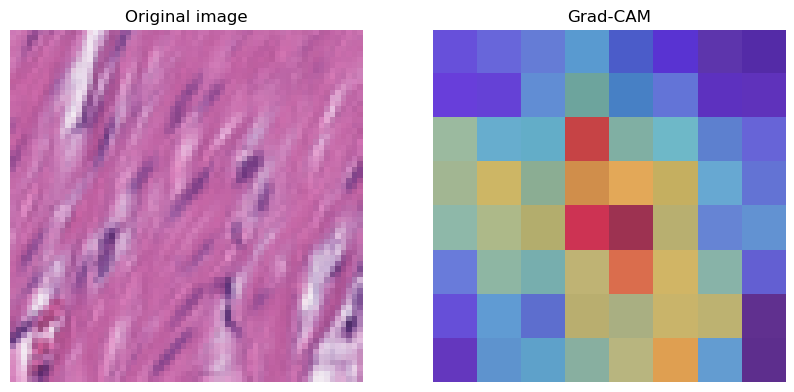

In [18]:
heatmap = grad_cam(model, img_array, layer_name)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original image")
plt.imshow(img_array)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(img_array)
plt.imshow(heatmap, cmap="jet", alpha=0.5)  
plt.axis("off")
plt.show()

### Heatmap on the scale of the input image

In [19]:
def overlay_heatmap(img, heatmap):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    colormap = cm.get_cmap('jet') 
    heatmap_colored = colormap(heatmap_resized)[:, :, :3]  
    
    img_normalized = img.astype('float32')
    
    heatmap_colored = heatmap_colored.astype('float32')

    overlay = cv2.addWeighted(img_normalized, 0.6, heatmap_colored, 0.4, 0)
    
    return overlay, heatmap_resized

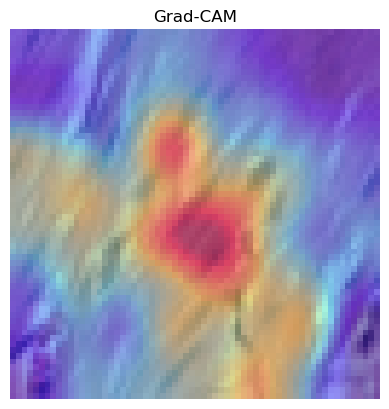

In [20]:
result, ob = overlay_heatmap(img_array, heatmap)
plt.imshow(result)
plt.axis("off")
plt.title("Grad-CAM")
plt.show()

### Heatmap with color scale

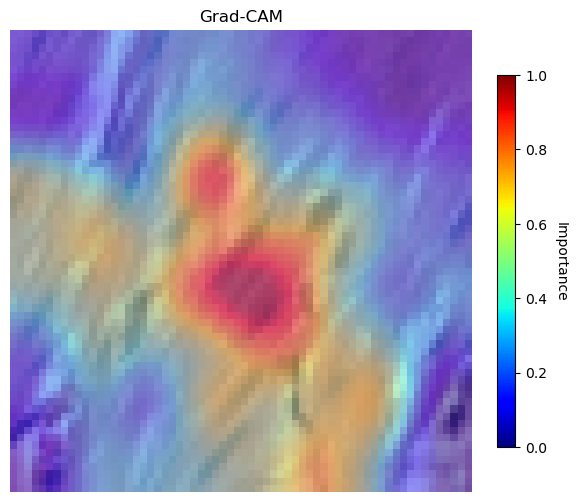

In [21]:
plt.figure(figsize=(8, 6))
plt.imshow(result)
plt.axis("off")

cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap='jet'),
    ax=plt.gca(),
    orientation='vertical',
    fraction=0.03,  
    pad=0.04      
)
cbar.set_label("Importance", rotation=270, labelpad=15)  
plt.title("Grad-CAM")
plt.show()

# Comparison of methods

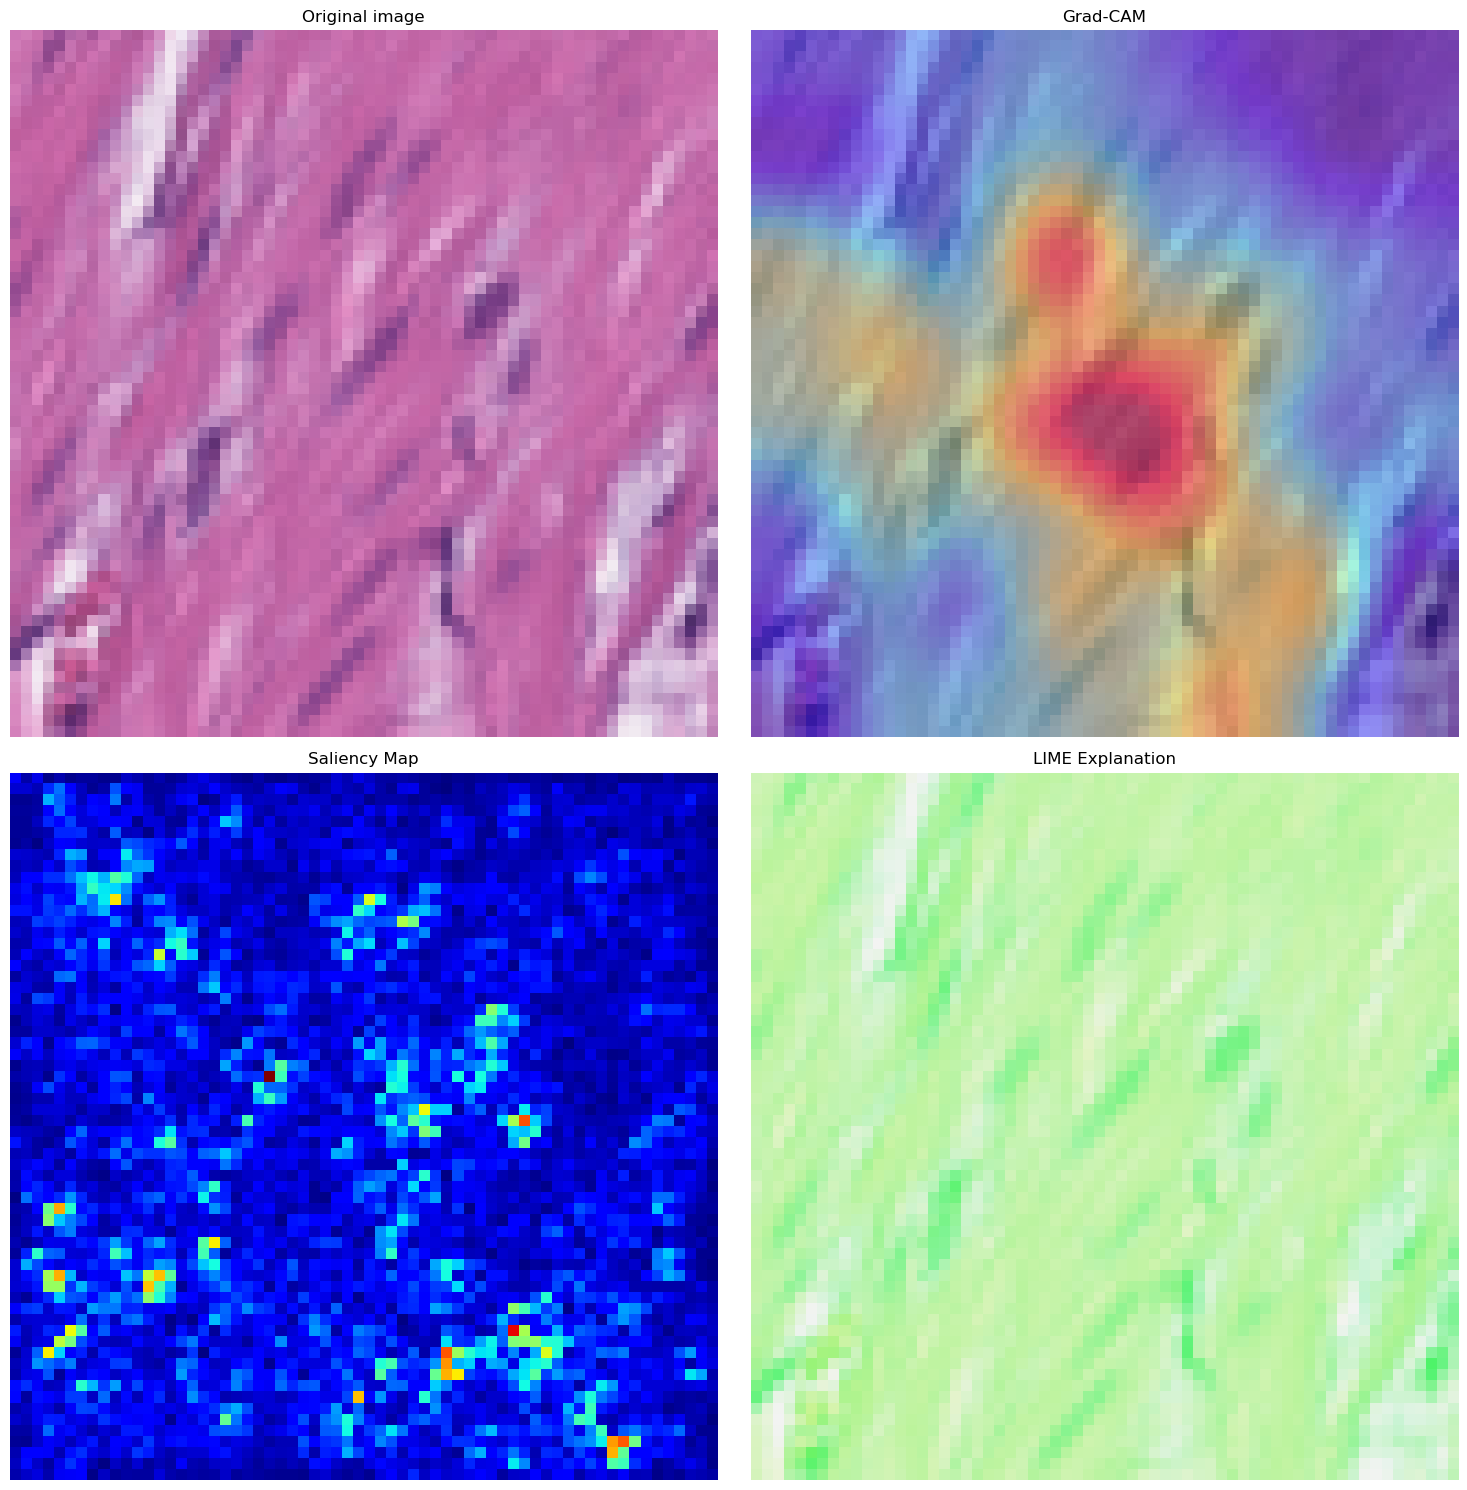

In [22]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.title("Original image")
plt.imshow(img_array)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(result)
plt.axis("off")
plt.title("Grad-CAM")

plt.subplot(2, 2, 3)
plt.title("Saliency Map")
plt.imshow(saliency_map, cmap='jet')
plt.axis("off")


ax = plt.subplot(2, 2, 4)
im = ax.imshow(explanation_text, cmap='jet')
plt.title("LIME Explanation")
plt.axis("off")

# Adding a color bar to the last subplot
# cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
# cbar.set_label("Intensywność", rotation=270, labelpad=15)


plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 63ms/step


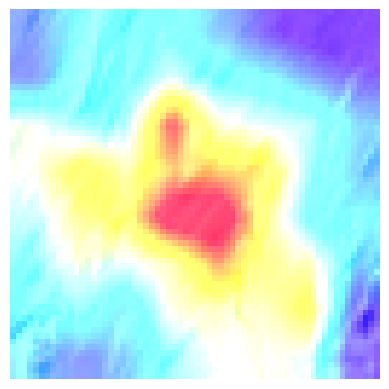

In [23]:
img_tensor = np.expand_dims(img_array, axis=0) 

explainer = GradCAM()

grid = explainer.explain(
    validation_data=(img_tensor, None),
    model = model,
    class_index=np.argmax(model.predict(img_tensor)),
    layer_name=layer_name,
    colormap=2) 


plt.imshow(grid)
plt.axis("off")
plt.show()